In [0]:
pip install s3fs

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import os
# To work with Amazon S3 storage, set the following variables using
# your AWS Access Key and Secret Key
# Set the Region to where your files are stored in S3.
access_key = 'AKIA***AWHA'
secret_key = 'MSuJ***0mX/'
# Set the environment variables so boto3 can pick them up later.
# Do not modify the next three lines of code
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F").replace("+", "%2B")
# Set aws_region to where your S3 bucket was created
aws_region = "us-east-2"

In [0]:
from pyspark.sql import SparkSession

# Create a SparkConf and SparkContext
spark = SparkSession.builder.appName("amazon-reviews-project").getOrCreate()

# Update the Spark options to work with our AWS Credentials
# Do not modify the next three lines
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")

In [0]:
sdf = spark.read.option("header", "true").option("delimiter", "\t").csv("s3://amazon-reviews-project-xh/raw/clean_amazon_reviews_multilingual_US_v1_00.tsv/*")
sdf_sample = sdf.sample(False, 0.05, seed=42)
sdf_sample.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-----------------+----------------+---------------------+--------------------+-----------------+-------------------+-----------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|clean_customer_id|clean_product_id|clean_review_headline|   clean_review_body|clean_star_rating|clean_helpful_votes|clean_total_votes|
+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-----------------+----------------+---------------------+----

In [0]:
from pyspark.sql.functions import length

# Create a new column
sdf_sample = sdf_sample.withColumn("review_length", length("review_body"))

# Filter rows
sdf_filtered = sdf_sample.filter(sdf["star_rating"] >= 4)
sdf_filtered.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-----------------+----------------+---------------------+--------------------+-----------------+-------------------+-----------------+-------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|clean_customer_id|clean_product_id|clean_review_headline|   clean_review_body|clean_star_rating|clean_helpful_votes|clean_total_votes|review_length|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-----------------+----------------+----------

Plot saved to S3.


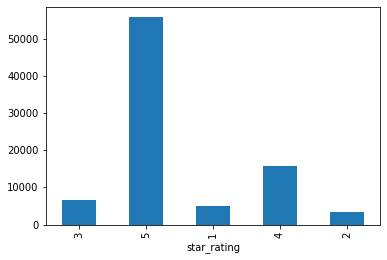

In [0]:
import matplotlib.pyplot as plt
import io
import s3fs
import pandas as pd

# Group by clean_star_rating and count the occurrences
rating_counts = sdf_sample.groupBy("star_rating").count()

# Check if the DataFrame has any rows
if rating_counts.count() > 0:
    # Plot distribution of star ratings
    plot_data = rating_counts.toPandas()
    plot_data.plot(kind="bar", x="star_rating", y="count", legend=False)
    
    # Save the plot to a buffer
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0)

    # Connect to the s3fs file system
    s3 = s3fs.S3FileSystem(anon=False)
    
    # Save the plot to S3
    with s3.open('s3://amazon-reviews-project-xh/model/star_rating_distribution.png', 'wb') as f:
        f.write(img_data.read())
        
    print("Plot saved to S3.")
else:
    print("No data to plot.")


In [0]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import length, col

# Drop rows with null values in the review body
sdf_sample = sdf_sample.dropna(subset=["clean_review_body"])

# Sample a balanced subset of the data
sdf_balanced = sdf_sample.sampleBy("clean_star_rating", fractions={1.0: 1.0, 2.0: 1.0, 3.0: 1.0, 4.0: 1.0, 5.0: 1.0}, seed=42)

# Tokenize text
tokenizer = Tokenizer(inputCol="clean_review_body", outputCol="words")
sdf_assembled = tokenizer.transform(sdf_balanced)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
sdf_assembled = remover.transform(sdf_assembled)

# Add a feature for the length of the text
sdf_assembled = sdf_assembled.withColumn("text_length", length(col("clean_review_body")))


In [0]:

from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Drop rows with null values in the review body
sdf_sample = sdf_sample.dropna(subset=["clean_review_body"])

# Tokenize text
tokenizer = Tokenizer(inputCol="clean_review_body", outputCol="words")
sdf_assembled = tokenizer.transform(sdf_sample)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
sdf_assembled = remover.transform(sdf_assembled)

# Add a feature for the length of the text
sdf_assembled = sdf_assembled.withColumn("text_length", length(col("clean_review_body")))

# Check if there are any non-empty documents
non_empty_documents = sdf_assembled.filter("size(filtered_words) > 0")

if non_empty_documents.count() == 0:
    print("No non-empty documents found after preprocessing. Check your data.")
else:
    print(f"Number of non-empty documents: {non_empty_documents.count()}")

# HashingTF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)

# IDF
idf = IDF(inputCol="raw_features", outputCol="features")

# Assemble features
assembler = VectorAssembler(inputCols=["text_length", "features"], outputCol="assembled_features")

# Convert 'clean_star_rating' to DoubleType
sdf_assembled = sdf_assembled.withColumn("clean_star_rating", sdf_assembled["clean_star_rating"].cast(DoubleType()))

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="assembled_features", labelCol="clean_star_rating")

# Create a pipeline
pipeline = Pipeline(stages=[hashingTF, idf, assembler, rf])

# Split the data into training and testing sets
(training_data, testing_data) = sdf_assembled.randomSplit([0.8, 0.2], seed=123)

# Define a parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Set up train-validation split
tvs = TrainValidationSplit(estimator=pipeline,
                            estimatorParamMaps=param_grid,
                            evaluator=MulticlassClassificationEvaluator(
                                labelCol="clean_star_rating",
                                predictionCol="prediction",
                                metricName="accuracy"
                            ),
                            trainRatio=0.8)  

# Fit the pipeline to the training data
tvs_model = tvs.fit(training_data)

# Make predictions on the testing data
predictions_tvs = tvs_model.transform(testing_data)

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="clean_star_rating",
    predictionCol="prediction",
    metricName="accuracy"
)

# Evaluate the model
accuracy_tvs = evaluator.evaluate(predictions_tvs)
print(f"Train-Validation Split Accuracy: {accuracy_tvs}")

Number of non-empty documents: 86645
Train-Validation Split Accuracy: 0.6364739183178326


In [0]:
# Get the best model from the cross-validation
best_model = tvs_model.bestModel

# Print the best model's parameters
print("Best Model Parameters:")
for param, value in best_model.stages[-1].extractParamMap().items():
    print(f"{param.name}: {value}")

# Access the best model's parameters directly
best_rf_model = best_model.stages[-1]
print("Best Random Forest Model Parameters:")
print(f"Num Trees: {best_rf_model.getNumTrees}")
print(f"Max Depth: {best_rf_model.getOrDefault('maxDepth')}")


Best Model Parameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: assembled_features
impurity: gini
labelCol: clean_star_rating
leafCol: 
maxBins: 32
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 10
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -5387697053847413545
subsamplingRate: 1.0
Best Random Forest Model Parameters:
Num Trees: 10
Max Depth: 15


In [0]:
feature_importances = tvs_model.bestModel.stages[-1].featureImportances
print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"Feature {i}: {importance}")

Feature Importances:
Feature 0: 0.0042269081072965975
Feature 1: 0.0
Feature 2: 0.00017318334882819147
Feature 3: 0.00012104806208168196
Feature 4: 0.0
Feature 5: 0.00017596207931325667
Feature 6: 0.0
Feature 7: 0.0
Feature 8: 0.00028622102258490467
Feature 9: 0.0
Feature 10: 0.0
Feature 11: 0.0
Feature 12: 0.0
Feature 13: 0.0
Feature 14: 0.0
Feature 15: 0.0
Feature 16: 0.00019123093602900325
Feature 17: 0.0
Feature 18: 0.0
Feature 19: 0.0
Feature 20: 0.0
Feature 21: 0.00026669932589354567
Feature 22: 0.0
Feature 23: 0.0
Feature 24: 0.0
Feature 25: 0.0
Feature 26: 0.00316167837933561
Feature 27: 0.0
Feature 28: 0.0
Feature 29: 0.0
Feature 30: 0.0
Feature 31: 0.0001357284329904918
Feature 32: 0.0
Feature 33: 0.0002447579617799197
Feature 34: 0.0
Feature 35: 0.0
Feature 36: 0.0
Feature 37: 0.0
Feature 38: 0.0
Feature 39: 3.7705679725565356e-05
Feature 40: 0.0
Feature 41: 0.0
Feature 42: 0.0
Feature 43: 0.00011319723558873227
Feature 44: 0.0
Feature 45: 0.009360550614904293
Feature 46: 0.

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import HashingTF, IDF, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import length
from pyspark.sql.types import DoubleType

# Create a new column
sdf_assembled = sdf_assembled.withColumn("review_length", length("review_body"))

# Convert "clean_star_rating" to DoubleType
sdf_assembled = sdf_assembled.withColumn("clean_star_rating", sdf_assembled["clean_star_rating"].cast(DoubleType()))

# HashingTF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)

# IDF
idf = IDF(inputCol="raw_features", outputCol="features")

# Assemble features
assembler = VectorAssembler(inputCols=["review_length", "features"], outputCol="assembled_features")

# Random Forest Classifier with Best Model Parameters
rf = RandomForestClassifier(
    featuresCol="assembled_features",
    labelCol="clean_star_rating",
    numTrees=10,
    maxDepth=15,
    impurity="gini",
    maxBins=32,
    seed=-5387697053847413545
)

# Create a pipeline
pipeline = Pipeline(stages=[hashingTF, idf, assembler, rf])

# Split the data into training and testing sets
(training_data, testing_data) = sdf_assembled.randomSplit([0.8, 0.2], seed=123)

# Fit the pipeline to the training data
model = pipeline.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="clean_star_rating",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6365316850557449


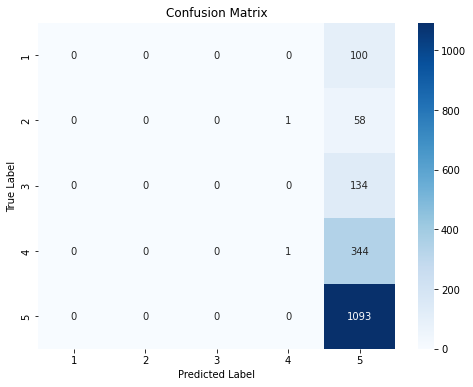

Confusion matrix plot saved to S3.
<Figure size 432x288 with 0 Axes>

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Sample a subset of predictions for visualization
sampled_predictions = predictions.select("clean_star_rating", "prediction").sample(False, 0.1, seed=42).toPandas()

# Create a confusion matrix
conf_matrix = confusion_matrix(sampled_predictions["clean_star_rating"], sampled_predictions["prediction"])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["1", "2", "3", "4", "5"], yticklabels=["1", "2", "3", "4", "5"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Save the plot to a buffer
img_data = io.BytesIO()
plt.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)

# Save the plot to S3
with s3.open('s3://amazon-reviews-project-xh/model/confusion_matrix.png', 'wb') as f:
    f.write(img_data.read())
    
print("Confusion matrix plot saved to S3.")

In [0]:
predictions.select("clean_star_rating", "prediction", "probability").show(truncate=False)


+-----------------+----------+---------------------------------------------------------------------------------------------------------+
|clean_star_rating|prediction|probability                                                                                              |
+-----------------+----------+---------------------------------------------------------------------------------------------------------+
|2.0              |5.0       |[0.0,0.04813807839076052,0.02783496132771871,0.05673758691614694,0.17253659299892415,0.6947527803664497] |
|3.0              |5.0       |[0.0,0.059107870460127686,0.043787020588723184,0.08790057720169797,0.1959946225102249,0.6132099092392262]|
|5.0              |5.0       |[0.0,0.05642563730399306,0.03468767868546185,0.06691802011926411,0.16712896374445813,0.6748397001468228] |
|5.0              |5.0       |[0.0,0.060538323494813716,0.04411110487946847,0.08643870736242447,0.19332851273964666,0.6155833515236466]|
|1.0              |5.0       |[0.0,0.1327

In [0]:
sdf_assembled.printSchema()


root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- clean_customer_id: string (nullable = true)
 |-- clean_product_id: string (nullable = true)
 |-- clean_review_headline: string (nullable = true)
 |-- clean_review_body: string (nullable = true)
 |-- clean_star_rating: double (nullable = true)
 |-- clean_helpful_votes: string (nullable = true)
 |-- clean_total_votes: string (nullabl

In [0]:
from pyspark.sql.functions import when

# Predict positive (1) for star ratings >= 4 and negative (0) otherwise
sdf_assembled = sdf_assembled.withColumn("binary_label", when(col("star_rating") >= 4, 1.0).otherwise(0.0))

In [0]:
from pyspark.ml.feature import HashingTF, IDF, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType  # Add this line to import DoubleType

# Convert "star_rating" and "helpful_votes" to DoubleType
sdf_assembled = sdf_assembled.withColumn("star_rating", sdf_assembled["star_rating"].cast(DoubleType()))
sdf_assembled = sdf_assembled.withColumn("helpful_votes", sdf_assembled["helpful_votes"].cast(DoubleType()))

# HashingTF for review text
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)

# IDF for review text
idf = IDF(inputCol="raw_features", outputCol="text_features")

# Assemble features including review length and other columns
assembler = VectorAssembler(inputCols=["review_length", "text_features", "star_rating", "helpful_votes"], outputCol="features")

# Logistic Regression Classifier
lr = LogisticRegression(featuresCol="features", labelCol="binary_label")

# Create a pipeline
pipeline_lr = Pipeline(stages=[hashingTF, idf, assembler, lr])

# Split the data into training and testing sets
(training_data_lr, testing_data_lr) = sdf_assembled.randomSplit([0.8, 0.2], seed=123)

# Fit the pipeline to the training data
model_lr = pipeline_lr.fit(training_data_lr)

# Make predictions on the testing data
predictions_lr = model_lr.transform(testing_data_lr)

# Convert "binary_label" to DoubleType 
predictions_lr = predictions_lr.withColumn("binary_label", col("binary_label").cast("double"))

# Evaluate the model
evaluator_lr = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_lr = evaluator_lr.evaluate(predictions_lr)

print(f"Area under ROC curve: {auc_lr}")


Area under ROC curve: 0.9897365708982567


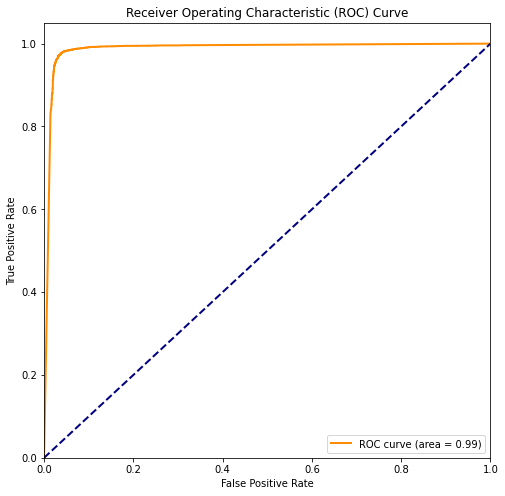

ROC curve plot saved to s3://amazon-reviews-project-xh/model/roc_curve.png
<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, IDF, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc
from pyspark.sql import SparkSession

# Convert "binary_label" to DoubleType (if not already done)
predictions_lr = predictions_lr.withColumn("binary_label", col("binary_label").cast("double"))

# Get the true labels and predicted probabilities
y_true = predictions_lr.select("binary_label").rdd.map(lambda row: float(row["binary_label"])).collect()
y_score = predictions_lr.select("probability").rdd.map(lambda row: float(row["probability"][1])).collect()

# Get the ROC curve data
fpr, tpr, _ = roc_curve(y_true, y_score)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the plot to a buffer
img_data = io.BytesIO()
plt.savefig(img_data, format='png')
img_data.seek(0)

# Connect to the S3 file system
s3 = s3fs.S3FileSystem(anon=False)

# Specify the S3 path where you want to save the plot
s3_path = 's3://amazon-reviews-project-xh/model/roc_curve.png'

# Save the plot to S3
with s3.open(s3_path, 'wb') as f:
    f.write(img_data.read())

print(f"ROC curve plot saved to {s3_path}")


In [0]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 7.7 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-546db7f1-3b22-45db-a127-bdefb58c54ed/bin/python -m pip install --upgrade pip' command.


In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import when
from pyspark.sql.types import DoubleType

analyzer = SentimentIntensityAnalyzer()
sdf_assembled = sdf_assembled.withColumn("vader_score", udf(lambda x: analyzer.polarity_scores(x)["compound"], DoubleType())("clean_review_body"))

# Categorize sentiment
sdf_assembled = sdf_assembled.withColumn("sentiment_category", when(col("vader_score") >= 0.05, "Positive")
                                          .when((col("vader_score") > -0.05) & (col("vader_score") < 0.05), "Neutral")
                                          .otherwise("Negative"))


In [0]:
# Show a sample of the DataFrame, including the relevant columns
sdf_assembled.select("clean_review_body", "vader_score", "sentiment_category").sample(False, 0.1, seed=42).show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
sdf_assembled.groupBy("sentiment_category").count().show()

+------------------+-----+
|sentiment_category|count|
+------------------+-----+
|          Positive|73231|
|           Neutral| 4099|
|          Negative| 9340|
+------------------+-----+



In [0]:
from pyspark.ml.feature import StringIndexer

# Define Labels
label_mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}

# Prepare Data
data = sdf_assembled.select("vader_score", "sentiment_category")
data = data.na.drop()  # Drop rows with missing values

# Convert String Labels to Numeric
indexer = StringIndexer(inputCol="sentiment_category", outputCol="label")
data = indexer.fit(data).transform(data)

# Vector Assembler
assembler = VectorAssembler(inputCols=["vader_score"], outputCol="features")
data = assembler.transform(data)

# Split Data
(training_data, testing_data) = data.randomSplit([0.8, 0.2], seed=123)

# Build a Model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[lr])
model = pipeline.fit(training_data)

# Make Predictions
predictions = model.transform(testing_data)

# Evaluate Model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",  
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8449540754433598


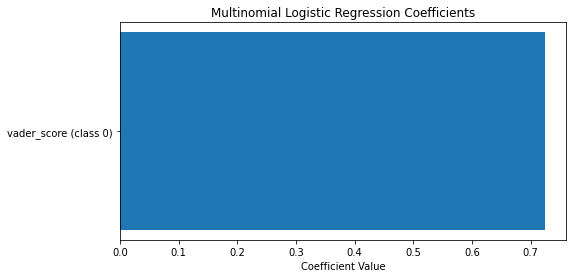

Coefficients plot saved to S3.
<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt

model = pipeline.fit(training_data)

# Extract coefficients from the Logistic Regression model
coefficients = model.stages[-1].coefficientMatrix.toArray()

# Get feature names 
feature_names = ["vader_score"]

# Visualize coefficients
plt.figure(figsize=(8, 4))
for i, feature_name in enumerate(feature_names):
    plt.barh(feature_name + f" (class {i})", coefficients[i, :])

plt.xlabel('Coefficient Value')
plt.title('Multinomial Logistic Regression Coefficients')
plt.show()

# Save the plot to a buffer
img_data = io.BytesIO()
plt.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)

# Save the plot to S3
with s3.open('s3://amazon-reviews-project-xh/model/coefficients_plot.png', 'wb') as f:
    f.write(img_data.read())

print("Coefficients plot saved to S3.")